# Continuous Wavelet Transform

> Simple wrapper around `pywt.cwt` to perform continuous wavelet transform.

In [ ]:
#| default_exp wavelets

In [ ]:
#| export
import pycwt
from pycwt import cwt
import fastcore.all as fc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import os
import io
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from uhina.loading import SpectralData
from sklearn.pipeline import Pipeline
from uhina.preprocessing import SNV, TakeDerivative

In [ ]:
#| hide
from uhina.loading import OSSLLoader, LoaderFactory
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#| eval: false
TEST_DATASET = 'fk-jumpei'

if TEST_DATASET == 'ringtrial':
    src = Path.home() / 'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001'
    loader = LoaderFactory.get_loader(src, 'ringtrial')
    data = loader.load_data(analytes='potassium_cmolkg')
    
elif TEST_DATASET == 'ossl':
    src = Path.home() / '.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz'
    loader = LoaderFactory.get_loader(src, 'ossl', 
                                      spectra_type='mir', 
                                      cfgs={'mir': {'ref_col': 'scan_mir.1500_abs', 'range': [650, 4000]}})
    data = loader.load_data(analytes='k.ext_usda.a725_cmolc.kg')

elif TEST_DATASET == 'fk-jumpei':
    src = Path.home() / 'pro/data/fk-jumpei'
    loader = LoaderFactory.get_loader(src, 'fk-jumpei')
    data = loader.load_data()
else: 
    raise ValueError(f"Dataset {TEST_DATASET} not found.")

print(f'X shape: {data.X.shape}')
print(f'y shape: {data.y.shape}')
print(f'smp_idx shape: {data.sample_indices.shape}')
print(f'y_names: {data.y_names}')
print(f'X_names: {data.X_names}')

X shape: (635, 1675)
y shape: (635, 21)
smp_idx shape: (635,)
y_names: ['soil_total_Cs134' 'soil_total_Cs137' 'soil_ex_Cs137'
 'exCs137_totalCs137' 'soil_water_soluble_K2O' 'soil_ex_K2O'
 'TF_plant_totalCs137' 'TF_plant_exCs137' 'soil_pH' 'soil_C' 'soil_N'
 'soil_CN_ratio' 'soil_CEC' 'soil_MgO' 'soil_CaO'
 'soil_P_absorption_coefficient' 'avaiable_Pi' 'course_sand' 'fine_sand'
 'silt' 'clay']
X_names: [ 650  652  654 ... 3996 3998 4000]


In [ ]:
#| exports
class CWT: 
    def __init__(self, data, dt=2, mother=pycwt.Morlet(6)):
        fc.store_attr()
        self.normalize()
        self.init_params()
        
    def init_params(self):
        self.N = self.data.size
        self.s0 = 2 * self.dt  # Starting scale, in this case 2 * 0.25 years = 6 months  
        self.dj = 1 / 12  # Twelve sub-octaves per octaves
        self.J = 7 / self.dj  # Seven powers of two with dj sub-octaves
            
    def normalize(self):
        self.std = self.data.std()  # Standard deviation
        self.var = self.std ** 2  # Variance
        self.data /= self.std  # Normalized dataset
    
    def get_wavelet(self):
        cwt_results = cwt(self.data, self.dt, self.dj, self.s0, self.J, self.mother)
        (self.wave, self.scales, self.freqs, self.coi, self.fft, self.fftfreqs) = cwt_results
    
    def get_powers(self):    
        self.power = (np.abs(self.wave)) ** 2
    
    def get_period(self): 
        self.period = 1 / self.freqs
    
    def __call__(self):
        self.get_wavelet()
        self.get_powers()
        self.get_period()
        return self

In [ ]:
#| exports
def plot_cwt(cwt, wavenumbers,
             dt=2, 
             figprops=dict(figsize=(6, 2), dpi=144), tight=True, 
             fontsize=8, title='', cmap=plt.cm.grey, save_path=None, 
             show_plot=True, show_coi:bool=False):
    "Plot the continuous wavelet transform."
    fig, ax = plt.subplots(**figprops)
    # if levels is None:
    #     levels = [np.percentile(cwt.power, p) for p in [10, 20, 30, 40, 50, 75, 90, 95, 99, 99.5]]
        
    # log2_levels = np.log2(levels)
    # contourf = ax.contourf(wavenumbers, np.log2(cwt.period), np.log2(cwt.power), 
    #                        log2_levels, extend='both', cmap=cmap)
    # extent = [wavenumbers.min(), wavenumbers.max(), 0, max(cwt.period)]

    im = ax.imshow(np.log2(cwt.power), aspect='auto', cmap=cmap,
                   extent=[wavenumbers.min(), wavenumbers.max(), 
                           np.log2(cwt.period.max()), np.log2(cwt.period.min())],
                   interpolation='nearest')
    
    # if show_coi:
    #     ax.fill(np.concatenate([wavenumbers, wavenumbers[-1:] + dt, wavenumbers[-1:] + dt,
    #                            wavenumbers[:1] - dt, wavenumbers[:1] - dt]),
    #             np.concatenate([np.log2(cwt.coi), [1e-9], np.log2(cwt.period[-1:]),
    #                            np.log2(cwt.period[-1:]), [1e-9]]),
    #             'black', alpha=0.5 if not save_path else 1, 
    #             hatch='x'
    #         )

    ax.set_xlim(wavenumbers.min(), wavenumbers.max())
    ax.set_ylim(np.log2(cwt.period.min()), np.log2(cwt.period.max()))
    # ax.set_ylim(8, np.log2(cwt.period.max()))

    if not save_path: 
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylabel('Period (wavenumbers)', fontsize=fontsize)
        if not tight: ax.set_xlabel('Wavenumber', fontsize=fontsize)  # Added x-axis label

    Yticks = 2 ** np.arange(np.ceil(np.log2(cwt.period.min())),
                               np.ceil(np.log2(cwt.period.max())))
    Yticks = Yticks.astype(int)

    ax.set_yticks(np.log2(Yticks))
    ax.set_yticklabels(Yticks, fontsize=fontsize-2)
    
    # Set major and minor ticks for x-axis
    ax.xaxis.set_major_locator(plt.MultipleLocator(500))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
    
    # Customize tick parameters
    ax.tick_params(axis='x', which='major', labelsize=fontsize-2)
    ax.tick_params(axis='x', which='minor', bottom=True)
    
    if not save_path:
        # Add grid for both major and minor ticks
        ax.grid(which='major', linestyle='-', linewidth='0.5', color='white', alpha=0.5)
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='white', alpha=0.5)
    
        # Create a new colorbar with correct logarithmic scaling
        # cbar = plt.colorbar(contourf, ax=ax, ticks=log2_levels)
        # cbar = plt.colorbar(im, ax=ax, ticks=log2_levels)
        # cbar.ax.set_yticklabels([f'{2**x:.1e}' for x in log2_levels])
        # cbar.ax.tick_params(labelsize=fontsize-2)
        # cbar.set_label('Power', fontsize=fontsize)
    
    if save_path:
        ax.axis('off')
        
        # plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=figprops['dpi'], bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        img = Image.open(buf).convert('L')  # Convert to black and white
        img.save(save_path)
        buf.close()
    
    if show_plot:
        plt.tight_layout()
        plt.show()
    else:
        plt.close(fig)  # Close the figure without displaying it

In [ ]:
#| eval: false
from dataclasses import astuple
X, X_names, y, y_names, smp_idx, ds_name, ds_label = astuple(data)

In [ ]:
#| eval: false
pipe = Pipeline([
    ('SNV', SNV()),
    ('Derivative', TakeDerivative())
])

X_trans = pipe.fit_transform(data.X)

In [ ]:
#| exports
# Outdated
import numpy as np

class OnlinePercentileEstimator:
    def __init__(self, percentiles):
        self.percentiles = percentiles
        self.values = []

    def update(self, array):
        self.values.extend(array.flatten())

    def calculate_percentiles(self):
        self.values = np.array(self.values)
        return np.percentile(self.values, self.percentiles)

Example usage:

In [ ]:
#| eval: false
array_list = [np.random.rand(85, 1700) for _ in range(10)]  # Replace with your actual arrays
percentiles = [10, 50, 90]

estimator = OnlinePercentileEstimator(percentiles)

for array in array_list:
    estimator.update(array)

results = estimator.calculate_percentiles()
print(results)

[0.10028646 0.50010463 0.8998105 ]


In [ ]:
#| exports
# Outdated
class OnlinePercentileEstimator:
    "Estimate the percentiles of the power of the wavelet transform of the spectra."
    def __init__(self, percentiles, n_samples=1000):
        self.percentiles = percentiles
        self.n_samples = n_samples
        self.values = np.empty((n_samples, len(percentiles)))
        self.current_index = 0
        self.is_full = False

    def update(self, array):
        array_flat = array.flatten()
        percentiles_values = np.percentile(array_flat, self.percentiles)
        n = len(percentiles_values)
        if self.current_index + 1 > self.n_samples:
            self.is_full = True
            self.current_index = 0  # Overwrite from the beginning if buffer is full
        self.values[self.current_index, :] = percentiles_values
        self.current_index += 1

    def calculate_percentiles(self):
        if self.is_full:
            combined_values = self.values
        else:
            combined_values = self.values[:self.current_index, :]
        return np.percentile(combined_values.flatten(), self.percentiles, axis=0)

In [ ]:
#| exports
# Outdated
def estimate_percentiles(X_trans, 
                         n_samples=100, 
                         percentiles=[10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]):
    "Estimate the percentiles of the power of the wavelet transform of the spectra."
    random_indices = np.random.choice(X_trans.shape[0], n_samples, replace=False)
    estimator = OnlinePercentileEstimator(percentiles)
    for i in tqdm(random_indices):
        estimator.update(CWT(X_trans[i, :])().power)
        
    return estimator.calculate_percentiles()


In [ ]:
#| eval: false
# Outdated
percentiles_result = estimate_percentiles(X_trans, 
                                          n_samples=100,
                                          percentiles=[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99])
percentiles_result

100%|██████████| 100/100 [00:00<00:00, 181.47it/s]


array([5.14356882e-03, 5.09074173e-02, 3.50768754e-01, 2.04215562e+00,
       8.17666232e+00, 2.48272509e+01, 4.12440530e+01, 5.88435369e+01,
       7.26961617e+01, 7.69870270e+01, 8.88923508e+01])

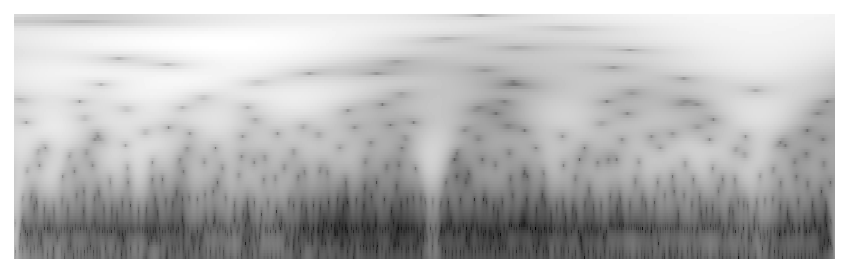

In [ ]:
#| eval: false
plot_cwt(CWT(X_trans[1, :])(), wavenumbers=data.X_names, 
         cmap=plt.cm.grey, save_path='../_data/test-1.png')

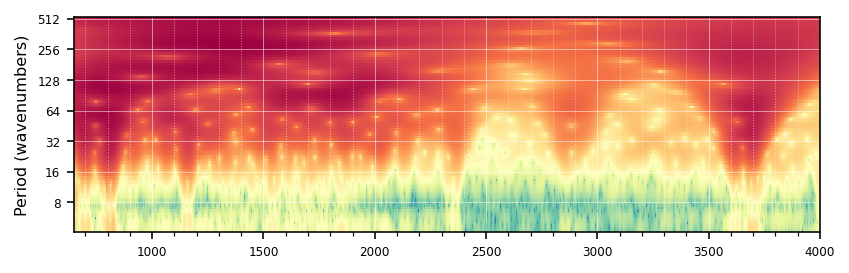

In [ ]:
#| eval: false
plot_cwt(CWT(X_trans[0, :])(), wavenumbers=data.X_names, cmap=plt.cm.Spectral_r)

In [ ]:
#| exports
def estimate_conversion_time(seconds=1000, samples=1000):
    "Estimate the time to convert all spectra to images."
    return seconds * (samples / 1000) / 60

In [ ]:
#| exports
def create_image_target_csv(data: SpectralData, # Spectra dataclass
                            n_samples: int = None, # number of samples to process
                            output_dir: str = '../_data/ossl-tfm/', # path to save the CSV file
                            fname: str = 'im-targets-lut.csv'
                            ) -> None: 
    "Create a CSV file with the image names and the target values."
    n_samples = len(data.sample_indices) if n_samples is None else n_samples
    items = {
        'fname': [f'{id}.png' for id in data.sample_indices[:n_samples]],
    }
    
    for i, y_name in enumerate(data.y_names):
        items[y_name] = [data.y[j, i].item() for j in range(n_samples)]
    
    df = pd.DataFrame(items)
    df.to_csv(Path(output_dir) / fname, index=False)

In [ ]:
#| eval: false
dst_dir = Path('../_data/fk-jumpei-tfm')
create_image_target_csv(data, n_samples=None, output_dir=dst_dir)  
pd.read_csv(dst_dir / 'im-targets-lut.csv').head()

635


,fname,soil_total_Cs134,soil_total_Cs137,soil_ex_Cs137,exCs137_totalCs137,soil_water_soluble_K2O,soil_ex_K2O,TF_plant_totalCs137,TF_plant_exCs137,soil_pH,...,soil_CN_ratio,soil_CEC,soil_MgO,soil_CaO,soil_P_absorption_coefficient,avaiable_Pi,course_sand,fine_sand,silt,clay
0,20-2013-paddy_rice.png,NaN,610.0,70.6,0.116,NaN,17.6,NaN,NaN,6.0,...,12.0,29.5,64.1,339.0,1700.0,NaN,17.1,34.1,25.6,23.2
1,28-2014-paddy_rice.png,NaN,273.5,27.8,0.102,NaN,62.1,NaN,NaN,5.0,...,12.0,19.6,30.3,217.0,660.0,12.2,NaN,NaN,NaN,NaN
2,33-2014-paddy_rice.png,NaN,28.1,3.6,0.127,NaN,22.3,NaN,NaN,6.0,...,12.0,13.8,38.1,96.1,640.0,6.8,NaN,NaN,NaN,NaN
3,35-2014-paddy_rice.png,NaN,897.8,71.4,0.080,NaN,33.6,NaN,NaN,5.0,...,12.0,15.4,16.2,119.0,640.0,34.2,NaN,NaN,NaN,NaN
4,36-2014-paddy_rice.png,NaN,964.3,90.6,0.094,NaN,57.0,NaN,NaN,5.0,...,12.0,17.7,19.9,151.0,610.0,40.0,NaN,NaN,NaN,NaN


In [ ]:
#| exports
def create_output_directory(output_dir):
    "Create the output directory if it does not exist."
    os.makedirs(output_dir, exist_ok=True)

In [ ]:
#| exports
def process_single_sample(args):
    "Process a single sample and save the wavelet image to the output directory."
    i, id, X_trans_i, wavenumbers, output_dir, cwt_kwargs, plot_kwargs = args
    fname_img = f'{output_dir}/{id}.png'
    cwt_result = CWT(X_trans_i, **cwt_kwargs)()
    plot_cwt(cwt_result, wavenumbers=wavenumbers, 
             save_path=fname_img, show_plot=False, **plot_kwargs)

In [ ]:
#| exports
def batch_indices(n_samples: int, batch_size: int) -> range:
    "Generate batch indices for processing."
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        yield range(start, end)

In [ ]:
#| exports
default_pipe = Pipeline([
    ('SNV', SNV()),
    ('Derivative', TakeDerivative())])

In [ ]:
#| exports
def convert_to_wavelet_images(data: SpectralData,
                              pipeline: Pipeline = default_pipe, # Scikit-learn pipeline
                              output_dir: str = '../_data/im',
                              cwt_kwargs: dict = None,
                              plot_kwargs: dict = None,
                              n_samples: int = None,
                              batch_size: int = 100,
                              n_workers: int = None,
                              ) -> None:
    "Process samples in parallel batches and save wavelet images to output directory."
    create_output_directory(output_dir)
    
    cwt_kwargs = cwt_kwargs or {}
    plot_kwargs = plot_kwargs or {}

    n_samples = len(data.sample_indices) if n_samples is None else min(n_samples, len(data.sample_indices))
    n_workers = n_workers or max(1, cpu_count() - 1)  # Use all cores except one by default
    
    X_trans = pipeline.fit_transform(data.X)
    
    with tqdm(total=n_samples, desc="Processing samples") as pbar:
        for batch in batch_indices(n_samples, batch_size):
            args = [(i, data.sample_indices[i], X_trans[i, :], data.X_names, output_dir, cwt_kwargs, plot_kwargs) for i in batch]
            with Pool(n_workers) as pool:
                pool.map(process_single_sample, args)
            
            pbar.update(len(batch))
    
    return None

In [ ]:
#| eval: false
convert_to_wavelet_images(data, 
                          output_dir='../_data/fk-jumpei-tfm/im', 
                          n_samples=200, 
                          batch_size=10)

Processing samples:   0%|          | 0/200 [00:00<?, ?it/s]

Processing samples: 100%|██████████| 200/200 [00:10<00:00, 18.49it/s]
